# Create a tile grid for an extent

In [1]:
pip install contextily

  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import box, Polygon
from pyproj import CRS, Transformer
import contextily as ctx

In [8]:
# read reference vect

ref_vect = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/AtlanticForest.shp'
# ref_vect = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg' 
# Load shapefile in WGS84
gdf_wgs84 = gpd.read_file(ref_vect)

###########################
# TESTING
##########################
# FOCAL_TILE = [4]
# FOCAL_TILE = [89]
# FOCAL_TILE = [99]

# # FOCAL_TILE = list(range(4))

# gdf_wgs84 = gdf_wgs84[gdf_wgs84['tile_num'].isin(FOCAL_TILE) ]
# gdf_wgs84 = gdf_wgs84.to_crs("EPSG:4326")

In [9]:
#  SIRGAS 2000 / Brazil Polyconic (EPSG:5880)
eae_crs = CRS.from_epsg(5880)

In [10]:
min_lon, min_lat, max_lon, max_lat = gdf_wgs84.total_bounds

In [11]:
# min_lon

In [12]:
dict_box = {
    # Define the bounding box
    'lat_lon_bbox': (min_lon, min_lat, max_lon, max_lat),  # (min_lon, min_lat, max_lon, max_lat)

    'aea_crs': eae_crs,

    'gpkg': ref_vect
}

In [13]:
lat_lon_bbox = dict_box['lat_lon_bbox']
aea_crs = dict_box['aea_crs']

In [14]:
# Create a transformer to convert bounds to projected CRS
transformer = Transformer.from_crs("EPSG:4326", aea_crs, always_xy=True)

min_x, min_y = transformer.transform(min_lon, min_lat)
max_x, max_y = transformer.transform(max_lon, max_lat)

In [15]:
# Calculate the dimensions of each grid cell in meters (90 km squared)
# 90 km
# cell_width = cell_height = 90 * 1_000  # Convert km² to m²
# cell_width

# 60 km
cell_width = cell_height = 60 * 1_000  # Convert km² to m²
cell_width


# 30 km
# cell_width = cell_height = 30 * 1_000  # Convert km² to m²
# cell_width

# 100 m
# cell_width = cell_height = 100  # Convert km² to m²
# cell_width

60000

In [16]:
# Create grid cells
x_coords = np.arange(min_x, max_x, cell_width)
y_coords = np.arange(min_y, max_y, cell_height)

grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + cell_width, y + cell_height))

# Create a GeoDataFrame from the grid cells
tile_grid = gpd.GeoDataFrame(
    {"geometry": grid_cells}, crs=aea_crs.to_string()
)



In [17]:
# Optionally reproject back to WGS84 (latitude/longitude) for visualization or export
tile_grid_wgs84 = tile_grid.to_crs("EPSG:4326")

# Save to a file (optional)
# grid_gdf_wgs84.to_file("grid_90sqkm_us.gpkg", driver="GPKG")

tile_grid["area_sq_km"] = tile_grid['geometry'].area/ 10**6

# Drop duplicates if needed
# tile_grid = tile_grid.drop_duplicates(subset="geometry")
# tile_grid['tile_num'] = tile_grid.reset_index().index + 1

In [18]:
# tile_grid.explore()

In [19]:
# Reproject input shapefile 
gdf_proj = gdf_wgs84.to_crs(tile_grid.crs)

# Keep only grid cells that intersect with the shapefile
tile_grid = gpd.sjoin(tile_grid, gdf_proj, how="inner", predicate="intersects")



In [20]:
# tile_grid.plot()

In [21]:
# Define tile numbers
tile_grid = tile_grid.drop(columns=["index_right"]).drop_duplicates(subset="geometry").reset_index(drop=True)

# Recalculate tile number
# tile_grid["tile_num"] = tile_grid.index + 1
tile_grid.insert(0, "tile_num", range(1, len(tile_grid) + 1))

In [22]:
# tile_grid.explore()

In [23]:
# len(tile_grid)

In [24]:
# type(tile_grid)

In [25]:
size_bytes = tile_grid.memory_usage(deep=True).sum()
print(f"Size in bytes: {size_bytes}")
print(f"Size in MB: {size_bytes / (1024**2):.2f} MB")

Size in bytes: 54158
Size in MB: 0.05 MB


In [27]:
# tile_grid.to_file('/projects/HLS/data/shp/atlantic_forest/tiles/br_af_grid90km_prj.gpkg')
tile_grid.to_file('/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/atlantic_forest/tiles/br_af_grid60km_prj.gpkg')
# tile_grid.to_file('/projects/my-private-bucket/HLS/data/shp/atlantic_forest/tiles/br_af_grid30km_prj.gpkg').


In [72]:
output_tile_fn = f'/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/tests/grid_100m_tile{FOCAL_TILE[0]}.gpkg'
tile_grid.to_file(output_tile_fn)

In [51]:
# 

In [73]:
import os
import glob


base = os.path.splitext(output_tile_fn)[0]  # remove .shp
files = glob.glob(base + ".*")

size_bytes = sum(os.path.getsize(f) for f in files)
print(f"Total shapefile size: {size_bytes / (1024**2):.2f} MB")


Total shapefile size: 225.90 MB


## Original code below

In [8]:
# dict_box_test = {
#     # Define the bounding box
#     # 'lat_lon_bbox': (-100, -10, 0, 10),  # (min_lon, min_lat, max_lon, max_lat)
#     # Define the Albers Equal Area projection 
#     'aea_crs': CRS.from_proj4(
#         #"+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=37.5 +lon_0=-96 +datum=WGS84 +units=m +no_defs"
#         #"+proj=aea +lat_1=20.5 +lat_2=35.5 +lat_0=27.5 +lon_0=-96 +datum=WGS84 +units=m +no_defs" (suitable for the US)
#         #"+proj=aea +lat_1=0 +lat_2=5 +lat_0=0 +lon_0=-50 +datum=WGS84 +units=m +no_defs" # Brasil
#     ),
#     'gpkg': '/projects/HLS/data/shp/atlantic_forest/tiles/ls_unit50km.gpkg'
# }    



dict_box_test = {
    # Define the bounding box
    'lat_lon_bbox': (-100, -10, 0, 10),  # (min_lon, min_lat, max_lon, max_lat)

    'aea_crs': CRS.from_proj4(
        "+proj=aea +lat_1=0 +lat_2=5 +lat_0=0 +lon_0=-50 +datum=WGS84 +units=m +no_defs"
    ),

    'gpkg': 'HLS/data/shp/atlantic_forest/AtlanticForest.shp'
}

In [14]:
# Nigeria
dict_box_nigeria = {
    'lat_lon_bbox': (-5,0,15,15),
    'aea_crs':  CRS.from_proj4("+proj=aea +lat_1=5 +lat_2=10 +lat_0=0 +lon_0=0 +datum=WGS84 +units=m +no_defs"),
    'gpkg': '/projects/my-public-bucket/databank/tile_grid_nigeria.gpkg'
}

In [15]:
dict_box = dict_box_nigeria

In [16]:
lat_lon_bbox = dict_box['lat_lon_bbox']
aea_crs = dict_box['aea_crs']

In [17]:
# Create a transformer to project lat-lon to Albers Equal Area
transformer = Transformer.from_crs("EPSG:4326", aea_crs, always_xy=True)

# Convert lat-lon bounding box to Albers Equal Area meters
min_x, min_y = transformer.transform(lat_lon_bbox[0], lat_lon_bbox[1])
max_x, max_y = transformer.transform(lat_lon_bbox[2], lat_lon_bbox[3])

# Calculate the dimensions of each grid cell in meters (90 square km)
#cell_width = cell_height = np.sqrt(90 * 1_000_000)  # Convert km² to m²

# Calculate the dimensions of each grid cell in meters (90 km squared)
cell_width = cell_height = 90 * 1_000  # Convert km² to m²

# Create grid cells
x_coords = np.arange(min_x, max_x, cell_width)
y_coords = np.arange(min_y, max_y, cell_height)

grid_cells = []
for x in x_coords:
    for y in y_coords:
        grid_cells.append(box(x, y, x + cell_width, y + cell_height))

# Create a GeoDataFrame from the grid cells
tile_grid = gpd.GeoDataFrame(
    {"geometry": grid_cells}, crs=aea_crs.to_string()
)

# Optionally reproject back to WGS84 (latitude/longitude) for visualization or export
tile_grid_wgs84 = tile_grid.to_crs("EPSG:4326")

# Save to a file (optional)
# grid_gdf_wgs84.to_file("grid_90sqkm_us.gpkg", driver="GPKG")

tile_grid["area_sq_km"] = tile_grid['geometry'].area/ 10**6

# Load administrative boundaries
admin_boundaries = gpd.read_file('/projects/my-public-bucket/databank/world-administrative-boundaries.geojson')

# Ensure boundaries are in Albers Equal Area projection
admin_boundaries = admin_boundaries[['name','continent','region','geometry']].to_crs(aea_crs)

# Filter grid tiles that intersect with the boundaries
tile_grid = gpd.sjoin(tile_grid, admin_boundaries, how="inner", predicate="intersects").drop('index_right', axis=1)

# Drop duplicates if needed
tile_grid = tile_grid.drop_duplicates(subset="geometry")

tile_grid['tile_num'] = tile_grid.reset_index().index + 1

In [18]:
tile_grid.explore()

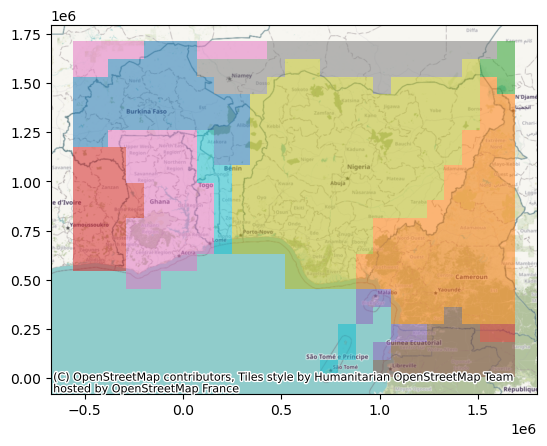

In [19]:
ax = tile_grid.plot(column='name', alpha=0.55)
ctx.add_basemap(ax=ax)

In [23]:
tile_grid.to_file(dict_box['gpkg'])

In [8]:
import fiona

gpkg = '/projects/my-public-bucket/databank/boreal_tiles_v004_model_ready.gpkg'
fiona.listlayers(gpkg)

['boreal_tiles_v004_model_ready']

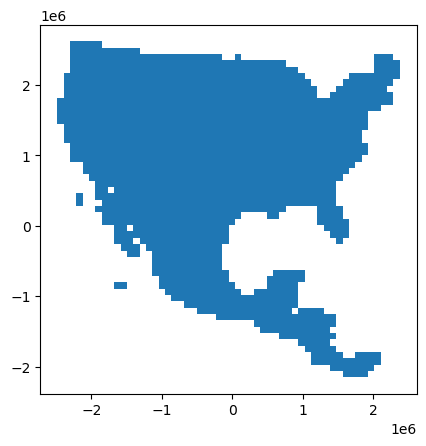

In [164]:
tile_grid_conus_centamerica = tile_grid[(tile_grid.name == 'United States of America') | (tile_grid.region == 'Central America')]
tile_grid_conus_centamerica.plot()
tile_grid_conus_centamerica.to_file('/projects/my-public-bucket/databank/tile_grid_conus_centamerica.gpkg')

In [163]:
tile_grid[(tile_grid.name == 'United States of America') | (tile_grid.region == 'Central America')].shape

(1494, 6)

### Select CONUS tiles - but this isnt perfect yet

In [156]:
tile_grid_conus_tmp1 = tile_grid[tile_grid.name == 'United States of America']
tile_grid_conus_tmp1_mex = tile_grid[(tile_grid.name == 'Mexico')]                            
#.to_file('/projects/my-public-bucket/databank/tile_grid_conus.gpkg')

### Intersection like this get all tiles, sets those you dont want to `null`

In [153]:
tile_grid_conus_tmp2 = gpd.sjoin(tile_grid_conus_tmp1, tile_grid, how="right", predicate='intersects').rename(
    columns={'tile_num_right': 'tile_num',
             'area_sq_km_right': 'area_sq_km',
             'name_right': 'name',
             'continent_right': 'continent',
             'region_right': 'region'
            })

In [157]:
#tile_grid_conus.drop_duplicates(subset=['tile_num_right']).explore(column='name_left')
tile_grid_conus_tmp1.drop_duplicates(subset=['tile_num']).explore(column='name')

### Drop `null` tiles

In [158]:
tile_grid_conus = tile_grid_conus_tmp2[tile_grid_conus_tmp2.tile_num_left.notnull()].drop_duplicates(subset=['tile_num'])
tile_grid_conus.explore()

### Drop extra cols, now its perfect

In [159]:
columns_to_drop = [col for col in tile_grid_conus.columns if 'left' in col]
tile_grid_conus.drop(columns=columns_to_drop, inplace=True)
tile_grid_conus.head()

,geometry,area_sq_km,name,continent,region,tile_num
337,"POLYGON ((-2393700.218 1449880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,1
338,"POLYGON ((-2393700.218 1539880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,2
339,"POLYGON ((-2393700.218 1629880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,3
340,"POLYGON ((-2393700.218 1719880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,4
404,"POLYGON ((-2303700.218 1179880.791, -2303700.2...",8100.0,United States of America,Americas,Northern America,5


In [160]:
tile_grid.head()

,geometry,area_sq_km,name,continent,region,tile_num
337,"POLYGON ((-2393700.218 1449880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,1
338,"POLYGON ((-2393700.218 1539880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,2
339,"POLYGON ((-2393700.218 1629880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,3
340,"POLYGON ((-2393700.218 1719880.791, -2393700.2...",8100.0,United States of America,Americas,Northern America,4
404,"POLYGON ((-2303700.218 1179880.791, -2303700.2...",8100.0,United States of America,Americas,Northern America,5


In [131]:
tile_grid_conus.to_file('/projects/my-public-bucket/databank/tile_grid_conus.gpkg')

In [132]:
tile_grid_conus.shape

(1178, 6)

In [135]:
gpkg = 'https://maap-ops-workspace.s3.amazonaws.com/shared/montesano/databank/tile_grid_conus.gpkg'
fiona.listlayers(gpkg)

['tile_grid_conus']

In [3]:
tile_grid_conus = gpd.read_file('s3://maap-ops-workspace/shared/montesano/databank/tile_grid_conus.gpkg')
tile_grid_conus.shape

(1178, 6)

## Select all CONUS NEON tiles

In [6]:
today_date = pd.Timestamp.now().date().strftime("%Y%m%d")
today_date

'20250318'

In [7]:
neon_sites_df = pd.read_csv(f'https://www.neonscience.org/field-sites/exports/NEON_Field_Site_Metadata_{today_date}.csv')
NEON_points_gdf = gpd.GeoDataFrame(neon_sites_df[['field_site_id']], geometry=gpd.points_from_xy(neon_sites_df['field_longitude'], neon_sites_df['field_latitude']), crs=4326)
NEON_points_gdf.head()

,field_site_id,geometry
0,ABBY,POINT (-122.33032 45.76244)
1,ARIK,POINT (-102.44715 39.75821)
2,BARC,POINT (-82.00841 29.67598)
3,BARR,POINT (-156.61936 71.28241)
4,BART,POINT (-71.28738 44.06389)


In [10]:
#tiles[tiles.intersects(NEON_points_gdf.to_crs(tiles.crs).geometry)]

tiles_NEON = gpd.sjoin(tile_grid_conus, NEON_points_gdf.to_crs(tile_grid_conus.crs), how='inner', predicate='contains').drop_duplicates(subset=['geometry'])
NEON_tiles_list = tiles_NEON.tile_num.to_list()

print(NEON_tiles_list)

tiles_NEON.explore(color='red')



[50, 52, 62, 63, 73, 262, 270, 293, 304, 365, 374, 434, 524, 525, 566, 608, 649, 743, 772, 786, 814, 855, 896, 929, 1106, 1170, 1209, 1311, 1316, 1353, 1428, 1438, 1467, 1515, 1547, 1575, 1680, 1716]
